In [ ]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from datetime import datetime
from datetime import timedelta
from time import time
from fbprophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA    
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## Подготовка некоторых полезных функций

In [ ]:
def specific_time(df, start, end):
    time=(df['Date']>start) & (df['Date']<=end)
    df=df.loc[time]
    plt.figure(figsize=(10, 5))
    figure=sns.lineplot(x='Date', y='Price', data=df)

In [ ]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [ ]:
def test_stationarity(ts):
    
    rolmean = ts.rolling(window=12).mean()
    rolstd = ts.rolling(window=12).std()

    
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
   
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts['Price'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### Подготовка данных

In [ ]:
df=pd.read_csv('BrentOilPrices.csv')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


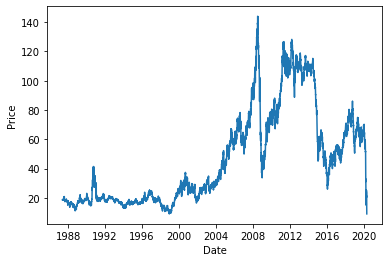

In [ ]:
sns.lineplot(x='Date', y='Price', data=df)

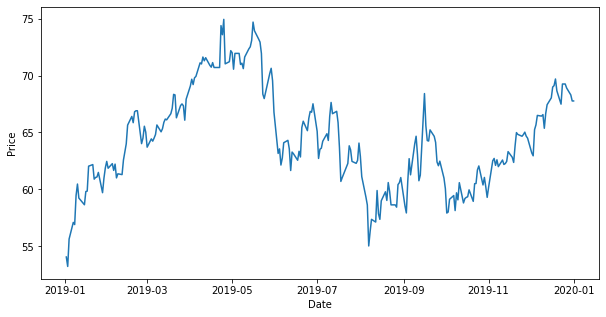

In [ ]:
specific_time(df, '2019-01-01', '2020-01-01')

In [ ]:
model_df=df
model_df.columns=['ds', 'y']
model_df.head()

,ds,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


## Предиктивная модель
#### FB Prophet

In [ ]:
model=Prophet(daily_seasonality=True)
model.fit(model_df)

In [ ]:
model_forecast=model.make_future_dataframe(periods=0)
forecast=model.predict(model_forecast)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1987-05-20,17.793421,2.763520,32.041839,17.793421,17.793421,-0.612393,-0.612393,-0.612393,-1.787011,-1.787011,-1.787011,-0.152179,-0.152179,-0.152179,1.326797,1.326797,1.326797,0.0,0.0,0.0,17.181028
1,1987-05-21,17.797226,2.817391,31.677872,17.797226,17.797226,-0.458959,-0.458959,-0.458959,-1.787011,-1.787011,-1.787011,0.001933,0.001933,0.001933,1.326119,1.326119,1.326119,0.0,0.0,0.0,17.338267
2,1987-05-22,17.801032,3.007261,32.641876,17.801032,17.801032,-0.548028,-0.548028,-0.548028,-1.787011,-1.787011,-1.787011,-0.084716,-0.084716,-0.084716,1.323698,1.323698,1.323698,0.0,0.0,0.0,17.253003
3,1987-05-25,17.812448,2.052477,31.862039,17.812448,17.812448,-0.520939,-0.520939,-0.520939,-1.787011,-1.787011,-1.787011,-0.040011,-0.040011,-0.040011,1.306084,1.306084,1.306084,0.0,0.0,0.0,17.291509
4,1987-05-26,17.816253,2.538955,31.595128,17.816253,17.816253,-0.661958,-0.661958,-0.661958,-1.787011,-1.787011,-1.787011,-0.171779,-0.171779,-0.171779,1.296832,1.296832,1.296832,0.0,0.0,0.0,17.154296


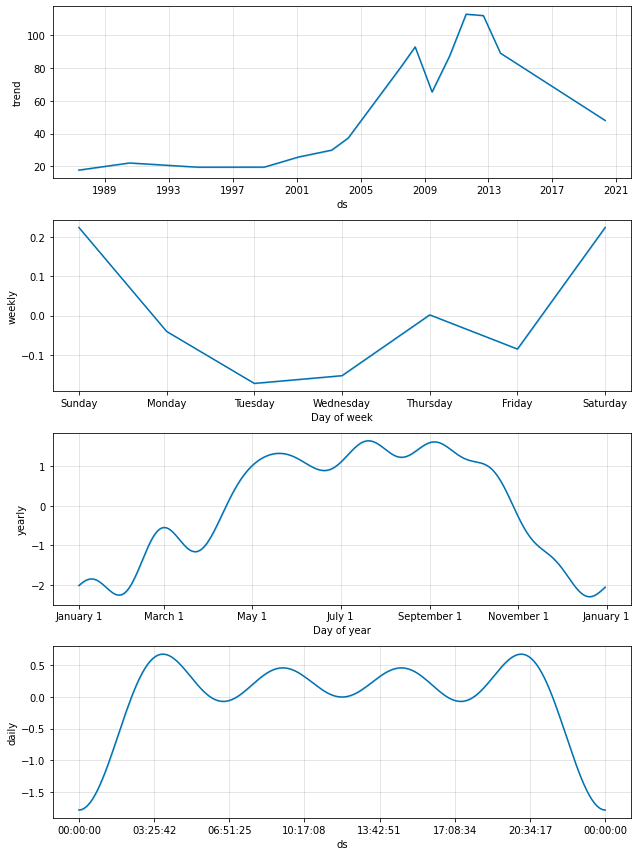

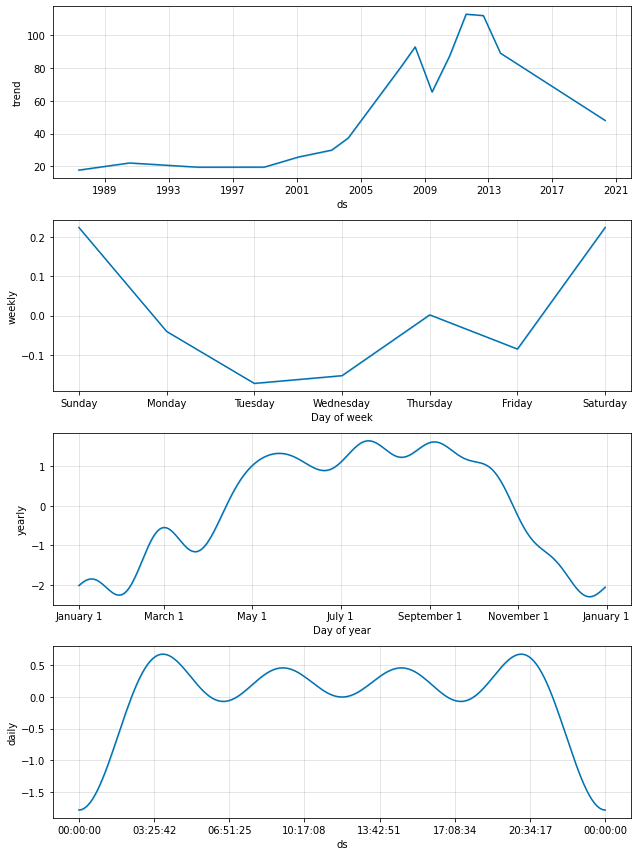

In [ ]:
model.plot_components(forecast)

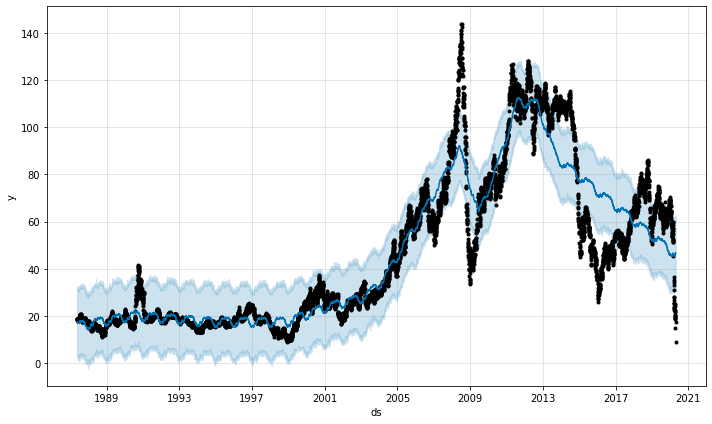

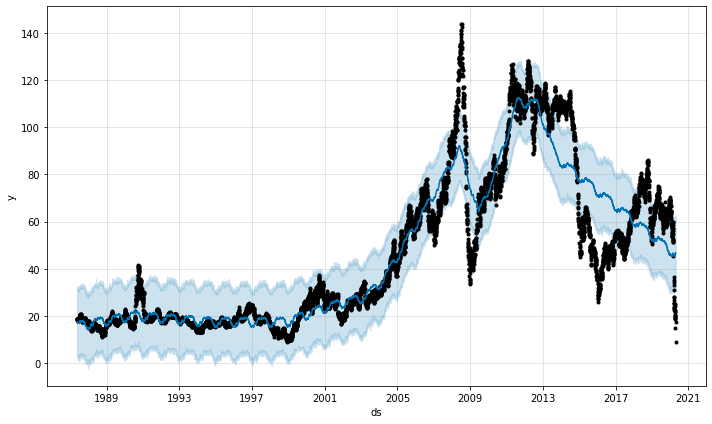

In [ ]:
model.plot(forecast)

In [ ]:
vis_df = forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']].join(model_df.set_index('ds'))

In [ ]:
vis_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2020-04-15,46.384095,32.207997,60.765444,19.80
2020-04-16,46.592823,32.399668,61.548066,18.69
2020-04-17,46.558772,31.613789,62.204225,19.75
2020-04-20,46.747459,31.122237,62.021205,17.36
2020-04-21,46.658692,31.332716,61.278083,9.12


In [ ]:
y_true=model_df['y']
y_predicted=vis_df['yhat']
mae=mean_absolute_error(y_true, y_predicted)
r2=r2_score(y_true, y_predicted)
mse=mean_squared_error(y_true, y_predicted)
print('prophet accuracy using mean absolute error=', mae)
print('prophet accuracy using mean squared error=', mse)
print('prophet accuracy using r2 score=', r2)

prophet accuracy using mean absolute error= 7.73668960157801
prophet accuracy using mean squared error= 133.20828176316627
prophet accuracy using r2 score= 0.8739068103759088


## Заключение 


 FB Prophet 
  **средняя квадратичная ошибка равна 132.6**
  
  Как видно из графиков до 2008 года нефть была весьма надежным инвестиционным активом, но после 2008 года и обвала многих биржевых показателей, на период 2014-2017 гг, она являлась высокорисковым активом, вкладывать в который имеет смысл при условии наличия экспертизы в геологоразведке, инженерии, а также понимания того как перерстроил свою работу нефтедобывающий бизнес. В настоящий момент наблюдается позитивное укрепление (относительно периода 2-3 лет) стоимости сырой нефти на рынке, по большей части оно основано на сокращении добычи, а не на развитии новых месторождений. Исходя из этого, а так же того что сакнционная политика отдельных стран оказывает влияние на стоимость сырой нефти, предсказывать с высокой точностью цены весьма затруднительно. Прогноз относительно стоимости: осторожный.